## Big Mac Price Analysis

In [1]:
# Import important libraries
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.formula.api as sm
from prophet import Prophet

In [2]:
# Initialize Spark Session
spark = SparkSession.builder.appName("Big Mac Price Analysis").getOrCreate()

#### Load Big Mac Index using Spark

In [3]:
# Replace 'big-mac-adjusted-index.csv' with available data source
df = spark.read.csv("big-mac-adjusted-index (1).csv", header=True, inferSchema=True)

In [4]:
# Load CPI data using Spark
CPI_df = spark.read.csv("CPIAUCSL.csv", header=True, inferSchema=True)

# Display to check data is loaded correctly
df.show(5)
CPI_df.show(5)

+----------+------+-------------+---------+-----------+-----------+----------------+----------------+----------------+--------+--------+--------+--------+-------+
|      date|iso_a3|currency_code|     name|local_price|  dollar_ex|    dollar_price|      GDP_bigmac|       adj_price|     USD|     EUR|     GBP|     JPY|    CNY|
+----------+------+-------------+---------+-----------+-----------+----------------+----------------+----------------+--------+--------+--------+--------+-------+
|2000-04-01|   ARG|          ARS|Argentina|        2.5|        1.0|             2.5|     7803.328512|1.92763294802718| 0.39805| 0.16574|-0.06353| 0.10595|0.96855|
|2000-04-01|   AUS|          AUD|Australia|       2.59|       1.68|1.54166666666667|29189.4477837838|2.31783022715204|-0.28301|-0.40215|-0.51973|-0.43281|0.00958|
|2000-04-01|   BRA|          BRL|   Brazil|       2.95|       1.79|1.64804469273743|4913.91077966102|1.87491450373695|-0.05247|-0.20992| -0.3653|-0.25044|0.33419|
|2000-04-01|   GBR|   

In [5]:
from pyspark.sql import functions as F
from pyspark.sql.types import DateType

# Filter the data for "United States" directly in Spark DataFrame
USA_df = df.filter(df["name"] == "United States")

# Convert 'date' column to Spark's DateType
USA_df = USA_df.withColumn("date", F.to_date(F.col("date"), "yyyy-MM-dd"))

# Preview result to verify filtering and date conversion
USA_df.show(5)

# Converssion of Pandas for certain operations:
USA_pandas_df = USA_df.toPandas()

# Reset index in Pandas if necessary
USA_pandas_df.reset_index(inplace=True)

+----------+------+-------------+-------------+-----------+---------+------------+----------+----------------+---+--------+--------+--------+-------+
|      date|iso_a3|currency_code|         name|local_price|dollar_ex|dollar_price|GDP_bigmac|       adj_price|USD|     EUR|     GBP|     JPY|    CNY|
+----------+------+-------------+-------------+-----------+---------+------------+----------+----------------+---+--------+--------+--------+-------+
|2000-04-01|   USA|          USD|United States|       2.24|      1.0|        2.24| 34496.241|2.41465453863794|0.0|-0.16617|-0.33016|-0.20893|0.40807|
|2001-04-01|   USA|          USD|United States|       2.24|      1.0|        2.24| 36312.782|2.38865009704946|0.0|-0.16759| -0.3327|-0.09432|0.22843|
|2002-04-01|   USA|          USD|United States|       2.35|      1.0|        2.35| 37101.453|2.47030052039839|0.0|-0.14409|-0.28257| 0.17002| 0.3068|
|2003-04-01|   USA|          USD|United States|       2.46|      1.0|        2.46| 37945.761| 2.7598

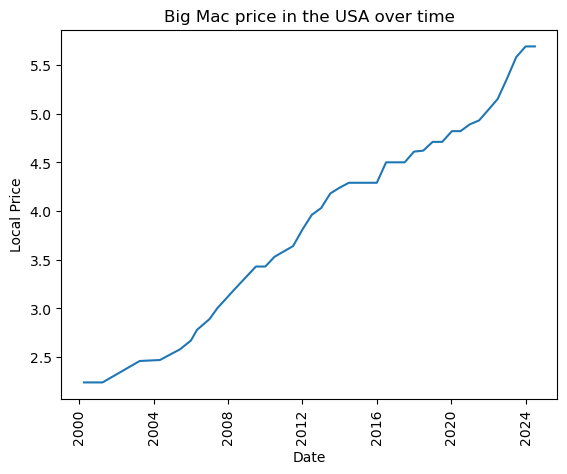

In [6]:
# Plot the Big Mac price in the USA over time
plt.plot(USA_pandas_df['date'], USA_pandas_df['local_price'])
plt.xlabel('Date')
plt.ylabel('Local Price')
plt.title('Big Mac price in the USA over time')
_ = plt.xticks(rotation=90)
plt.show()

In [7]:
# Convert both DataFrames to Pandas
USA_pandas_df = USA_df.toPandas()
CPI_df_pandas = CPI_df.toPandas()

# Ensure 'date' and 'DATE' columns are in datetime format
USA_pandas_df['date'] = pd.to_datetime(USA_pandas_df['date'])
CPI_df_pandas['DATE'] = pd.to_datetime(CPI_df_pandas['DATE'])

# Merge the two Pandas DataFrames on 'date' and 'DATE'
merged_df = pd.merge(USA_pandas_df, CPI_df_pandas, left_on='date', right_on='DATE', how='inner')

# Preview merged dataframe results
print(merged_df.head())

        date iso_a3 currency_code           name  local_price  dollar_ex  \
0 2000-04-01    USA           USD  United States         2.24        1.0   
1 2001-04-01    USA           USD  United States         2.24        1.0   
2 2002-04-01    USA           USD  United States         2.35        1.0   
3 2003-04-01    USA           USD  United States         2.46        1.0   
4 2004-05-01    USA           USD  United States         2.47        1.0   

   dollar_price  GDP_bigmac  adj_price  USD      EUR      GBP      JPY  \
0          2.24   34496.241   2.414655  0.0 -0.16617 -0.33016 -0.20893   
1          2.24   36312.782   2.388650  0.0 -0.16759 -0.33270 -0.09432   
2          2.35   37101.453   2.470301  0.0 -0.14409 -0.28257  0.17002   
3          2.46   37945.761   2.759847  0.0 -0.30082 -0.31809  0.13452   
4          2.47   39405.354   2.860668  0.0 -0.34789 -0.33361  0.05940   

       CNY       DATE  CPIAUCSL  
0  0.40807 2000-04-01     170.9  
1  0.22843 2001-04-01     176.

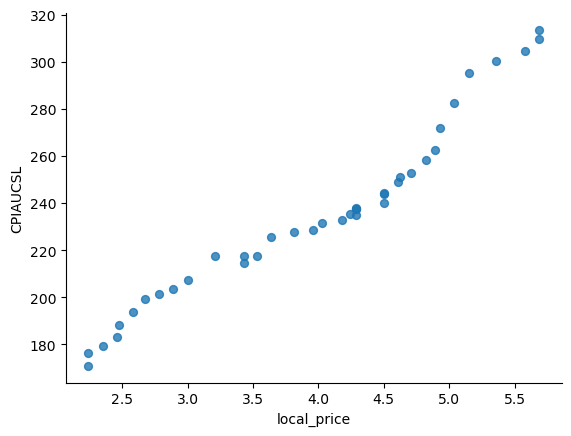

In [8]:
# Visualize local price vs CPIAUCSL
merged_df.plot(kind='scatter', x='local_price', y='CPIAUCSL', s=32, alpha=0.8)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

In [9]:
# Calculate correlation between 'local_price' and 'CPIAUCSL'
correlation = merged_df[["local_price", "CPIAUCSL"]].corr(numeric_only=True)
print("Correlation between Local Price and CPIAUCSL:\n", correlation)

Correlation between Local Price and CPIAUCSL:
              local_price  CPIAUCSL
local_price       1.0000    0.9706
CPIAUCSL          0.9706    1.0000


### Linear Regression Model

In [10]:
# Prepare data for regression
X = merged_df[['local_price']]
y = merged_df['CPIAUCSL']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Training a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 77.17459868777966
R-squared: 0.9447790496840578


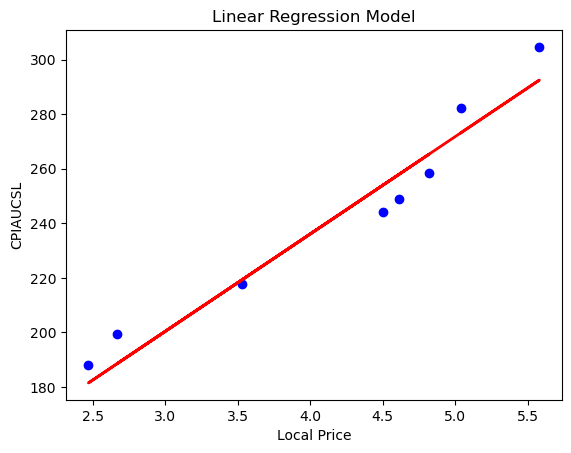

In [12]:
# Plot Regression Line
plt.scatter(X_test, y_test, color='blue')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.xlabel('Local Price')
plt.ylabel('CPIAUCSL')
plt.title('Linear Regression Model')
plt.show()

### OLS Regression with Statsmodels

In [13]:
# Create OLS regression model using statsmodels
ols_model = sm.ols('CPIAUCSL ~ local_price', data=merged_df)
results = ols_model.fit()

# Print the summary of model
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:               CPIAUCSL   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     601.6
Date:                Wed, 18 Sep 2024   Prob (F-statistic):           1.74e-24
Time:                        11:50:31   Log-Likelihood:                -140.58
No. Observations:                  39   AIC:                             285.2
Df Residuals:                      37   BIC:                             288.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      94.6677      5.919     15.993      

### Time Series Forecasting with Prophet Library

11:50:32 - cmdstanpy - INFO - Chain [1] start processing
11:50:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


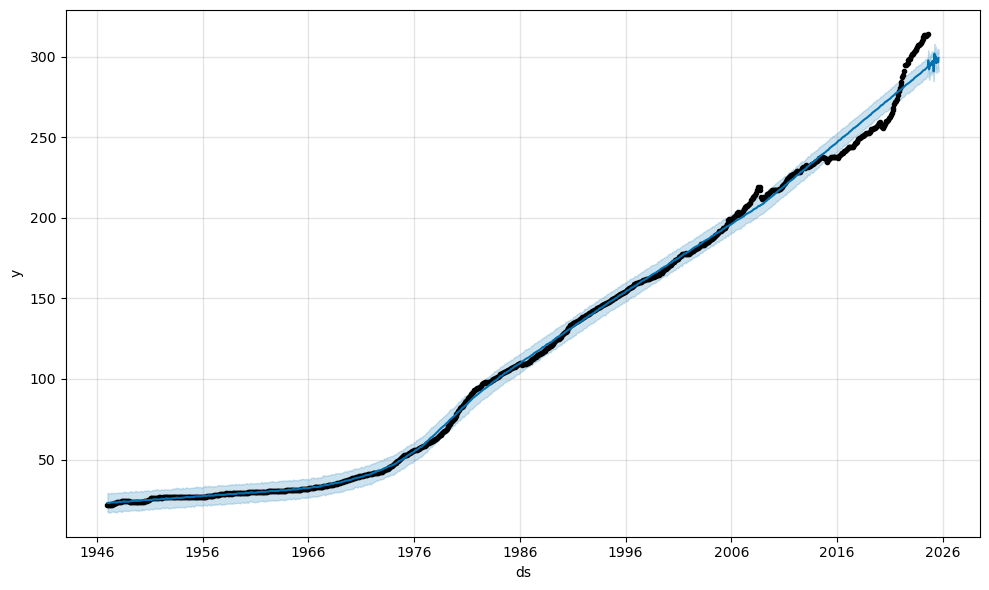

In [14]:
# Prepare the CPI data for Prophet
prophet_df = CPI_df_pandas[['DATE', 'CPIAUCSL']].rename(columns={'DATE': 'ds', 'CPIAUCSL': 'y'})

# Create and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_df)

# Create a future dataframe for 365 days into the future
future = prophet_model.make_future_dataframe(periods=365)

# Make predictions
forecast = prophet_model.predict(future)

# Plot the forecast
prophet_model.plot(forecast)
plt.show()

C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

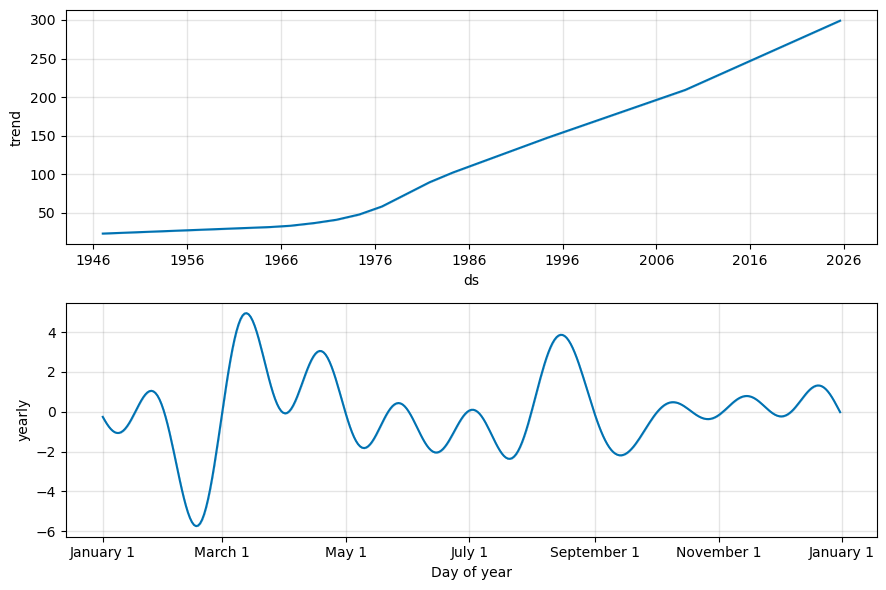

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1947-01-01,23.167115,17.438974,29.111427,23.167115,23.167115,-0.165232,-0.165232,-0.165232,-0.165232,-0.165232,-0.165232,0.0,0.0,0.0,23.001883
1,1947-02-01,23.206814,17.642704,29.155895,23.206814,23.206814,-0.084139,-0.084139,-0.084139,-0.084139,-0.084139,-0.084139,0.0,0.0,0.0,23.122675
2,1947-03-01,23.242671,16.959466,29.027576,23.242671,23.242671,-0.359123,-0.359123,-0.359123,-0.359123,-0.359123,-0.359123,0.0,0.0,0.0,22.883548
3,1947-04-01,23.282370,17.277320,29.016095,23.282370,23.282370,-0.073398,-0.073398,-0.073398,-0.073398,-0.073398,-0.073398,0.0,0.0,0.0,23.208972
4,1947-05-01,23.320789,17.384931,29.361630,23.320789,23.320789,0.061725,0.061725,0.061725,0.061725,0.061725,0.061725,0.0,0.0,0.0,23.382513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,2025-07-28,299.037022,291.832190,303.746244,299.032564,299.096550,-1.252677,-1.252677,-1.252677,-1.252677,-1.252677,-1.252677,0.0,0.0,0.0,297.784345
1293,2025-07-29,299.051910,292.542628,303.774206,299.047098,299.111698,-0.942114,-0.942114,-0.942114,-0.942114,-0.942114,-0.942114,0.0,0.0,0.0,298.109795
1294,2025-07-30,299.066797,292.932420,304.307079,299.061632,299.126847,-0.604482,-0.604482,-0.604482,-0.604482,-0.604482,-0.604482,0.0,0.0,0.0,298.462315
1295,2025-07-31,299.081685,293.107474,304.521967,299.076204,299.141995,-0.245077,-0.245077,-0.245077,-0.245077,-0.245077,-0.245077,0.0,0.0,0.0,298.836608


In [15]:
# Plot forecast components
prophet_model.plot_components(forecast)
plt.show()

# Display the forecast DataFrame
forecast